#  Neural Network for Customer Churn Prediction


In [26]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score



# Load and preprocess data


In [27]:
df = pd.read_csv('bank-customer-churn-prediction-challenge/train.csv')
df.drop([ 'CustomerId', 'Surname'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Split features and target


In [28]:
X = df.drop('Exited', axis=1)
y = df['Exited']

# Handle missing values


In [29]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features


In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split


In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [32]:
def preprocess(df):
    df = df.copy()
    for col in ['id', 'CustomerId', 'Surname']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
    return df

# Build neural network model


In [33]:
model = MLPClassifier(hidden_layer_sizes=(64, 32), 
                          activation='relu', 
                          solver='adam',
                          max_iter=200,
                          random_state=42)



# Train model


In [34]:
history = model.fit(X_train, y_train)
joblib.dump(model, 'model_mlp.pkl')
joblib.dump(imputer, "imputer.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns, "feature_columns.pkl")

print("MLP model and preprocessors saved.")
print("Model saved as model_mlp.pkl")


MLP model and preprocessors saved.
Model saved as model_mlp.pkl


/Users/hasit/Desktop/ME/kaggle/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Evaluate model


In [35]:
y_pred_proba = model.predict(X_val).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(classification_report(y_val, y_pred))

Accuracy: 0.8917
F1 Score: 0.7075
ROC AUC: 0.8076
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93      2413
         1.0       0.75      0.67      0.71       587

    accuracy                           0.89      3000
   macro avg       0.84      0.81      0.82      3000
weighted avg       0.89      0.89      0.89      3000



# Accuracy


/Users/hasit/Desktop/ME/kaggle/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hasit/Desktop/ME/kaggle/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hasit/Desktop/ME/kaggle/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hasit/Desktop/ME/kaggle/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

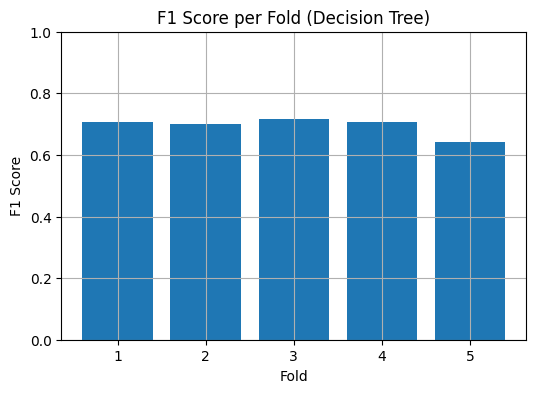

In [36]:
scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')

plt.figure(figsize=(6, 4))
plt.bar(range(1, 6), scores)
plt.title("F1 Score per Fold (Decision Tree)")
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Load Test Data

In [37]:

test_df = pd.read_csv("bank-customer-churn-prediction-challenge/test.csv")

# Preprocess
X_test_raw = preprocess(test_df)

# Align columns with training set
feature_columns = joblib.load("feature_columns.pkl")
X_test_raw = X_test_raw.reindex(columns=feature_columns, fill_value=0)
# Apply imputer and scaler
imputer = joblib.load("imputer.pkl")
scaler = joblib.load("scaler.pkl")
X_test_imputed = imputer.transform(X_test_raw)
X_test_scaled = scaler.transform(X_test_imputed)

# Load model and predict probabilities
model = joblib.load("model_mlp.pkl")
probas = model.predict(X_test_scaled).flatten()
# Build submission
submission = pd.DataFrame({
    'id': test_df['id'] if 'id' in test_df.columns else test_df['CustomerId'],
    'Exited': probas
})
submission.to_csv("submission_mlp.csv", index=False)

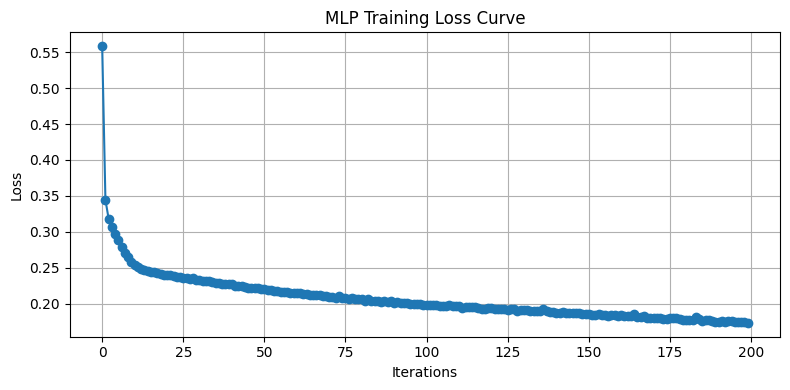

In [38]:
# Plot MLP loss curve
plt.figure(figsize=(8, 4))
plt.plot(model.loss_curve_, marker='o')
plt.title("MLP Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

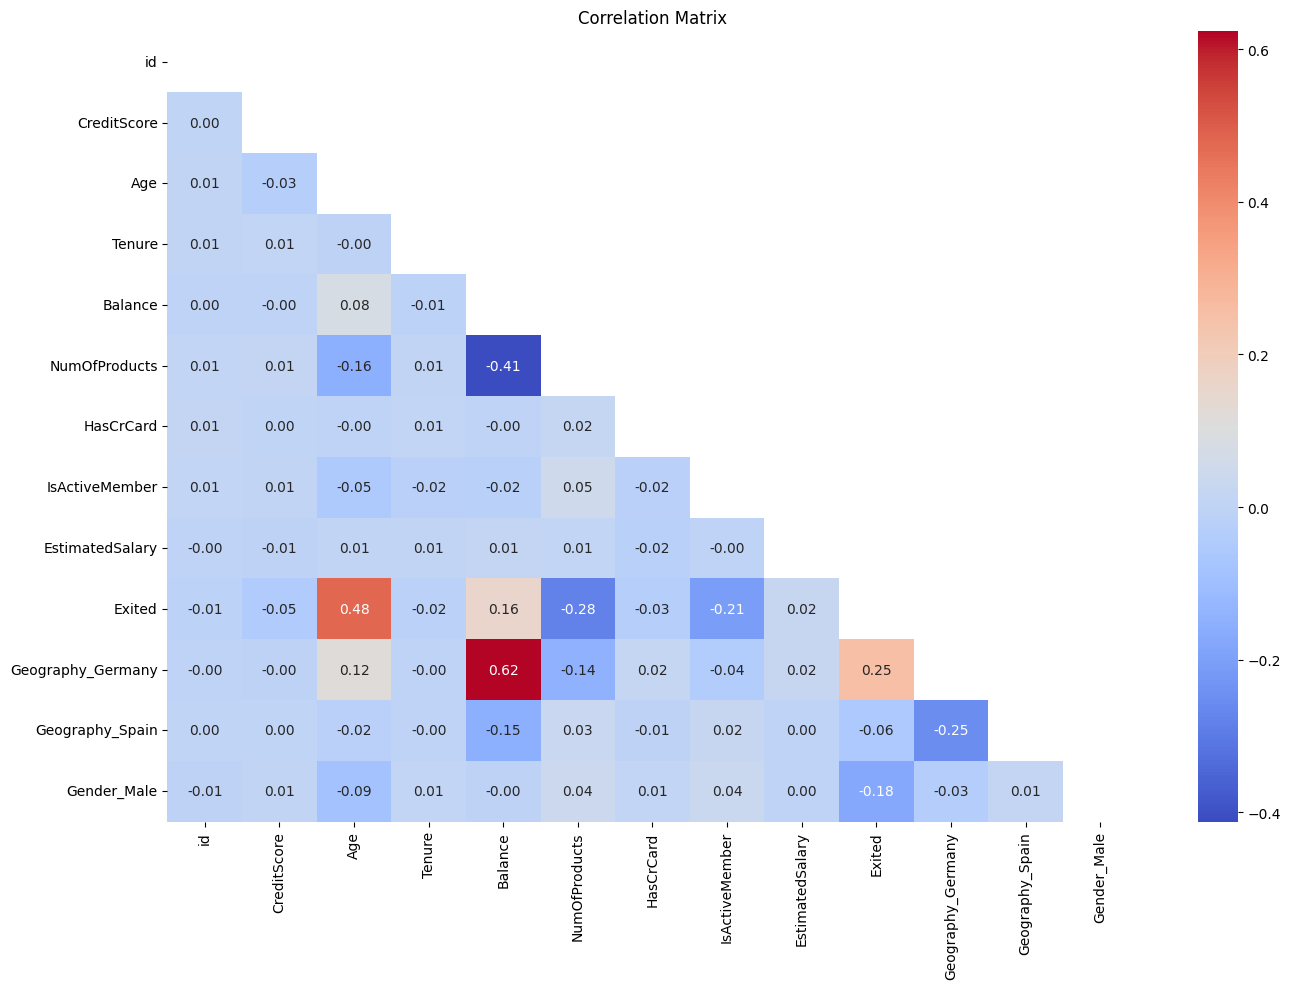

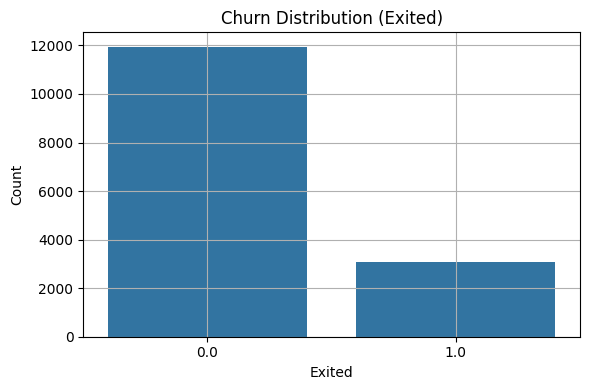

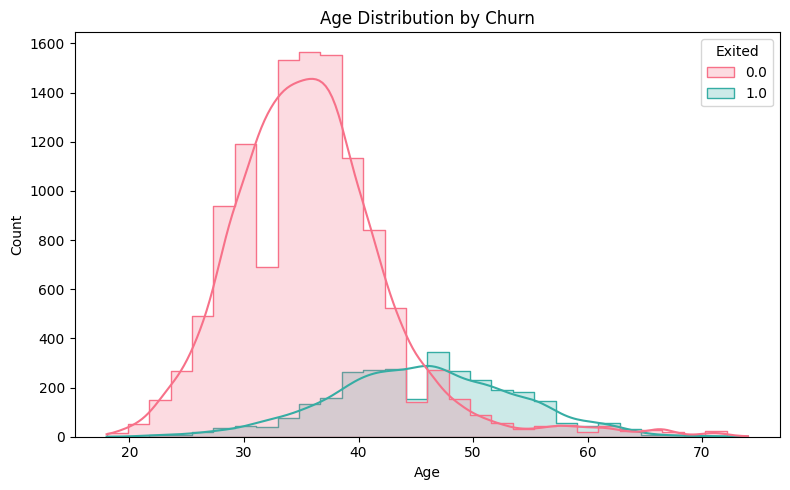

In [39]:

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Correlation Heatmap
plt.figure(figsize=(14, 10))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 2. Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=df)
plt.title("Churn Distribution (Exited)")
plt.xlabel("Exited")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Age distribution by churn
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Age', hue='Exited', kde=True, bins=30, palette="husl", element="step")
plt.title("Age Distribution by Churn")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
